# LASSI Quick Tutorial
 
 This is a quick tutorial on how to use the Python helper scripts to generate phase diagrams. The general flow is:
 1. Have a (template) keyfile and energy files.
 2. Decalre an instance of LASSI.Sim_Setup module to run basic setup.
 3. Setup the structure of the system you want to simulate.
 3. Setup the concentrations and temperatures you want to sample.
 4. Define MC steps you wish to run the simulations for.
 5. Setup all the directories, and generate the keyfiles for each condition.
 6. Run the simulations. (At PappuLab we have access to a private cluster so queue submission is very simple)
 7. Declare an instance of LASSI.Analysis() to get ready for data analysis.
 8. Use LASSI.Analysis() to collect all the data, process the data, and generate the order parameters for density inhomogeneity and percolation.
 9. Plot contour maps.

In [ ]:
import LASSI as lassi #Importing the LASSI module
import seaborn as sns #For prettier plots -- can remove if you don't care
"""
The following set of commands are how I view most plots and you should change things to suit your needs/monitor.
"""
%pylab inline         
pylab.rcParams['figure.figsize']=(10,8)
sns.set()
sns.set_style("white")
sns.set_style("ticks")
sns.set_context('paper')
pylab.rcParams['font.family']='STIXGeneral'
pylab.rcParams['mathtext.fontset'] = 'stix'
pylab.rcParams['xtick.labelsize'] = 24
pylab.rcParams['ytick.labelsize'] = 24      

### Note that there are, for every concentration of every system, two different types of simulations. One simulation is with the desired interactions that we want (WInt), and one is without *any* interactions (NoInt). NoInt runs are in effect *ideal molecule* runs where the prior for the radial distribution functions (RDFs) are sampled. For WInt runs, we start at an initial temperature and ramp up (or down if you want) to a pre-defined final temperature where you should make sure that each temperature cycle is long enough. There isn't a good obvious *a priori* way to know the correct number so trial runs might be necessary.

#### The following is a simple example of a 2-component (*pseudo*-3-component with the solvent). The system contains a 1000 each of 2 chains with 5 monomers 3 lattice sites apart - an example of an implicit linker polymer. To generate the phase diagram, we sample the conc. vs. T. plane in a 35 x 35 regular grid, and produce contours of the relevnt order parameters.

In [204]:
reload(lassi)
mySysName = 'BigEx'; #My name for the example system
# LASSI.Sim_Setup() expects, in order, an array of system names, an array of linker lengths, 
# and a (template) keyfile
mySetup = lassi.Sim_Setup([mySysName], ['1.0'], 'paramFast.key') 
# paramFast does not output anything other than the cluster info and pdfs
# Use param.key if you want to also store trajectories, acceptance ratios, and energies

#Path where you want all the simulations, and directory trees.
mySetup.Set_SimulationPath('/home/fdar/Work/LASSI/PythonCodes/BetaPrep/')

"""
The following three functions are used to generate qsub-like commands where we have
'QSUB_COMMAND QSUB_QUEUE ${SysName}_${RunIt} ${PathToLASSI}'
If you have a different way to submit jobs to a queue, make the appropriate changes to the LASSI module.
NOTE: I am using shell=True with the subprocess module, so be careful with the next three functions!
"""

#The path to a working compiled LASSI executible
mySetup.Set_PathToLASSI('/work/fdar/GIT_LASSI/GIT_Repos/LASSI_GIT/lassi')
#The qsub command
mySetup.Set_QSUB_Command('cs_edam')
#The queues to run NoInt and WInt runs respectively.
mySetup.Set_QSUB_Queues('LION','LION')

# The two energy files for all systems. Can use mySetup.AddEnergyFileTo() later to have different files for
# different systems
mySetup.AddEnergyFiles_ForAll('energyNO.prm', 'energyInt.prm')


mySetup.ResetStruc(mySysName) #Just an extra precaution
#1000 chains with valency 5, and 3 lattice units between consecutive monomers
mySetup.AddStruc_ImpLinear(mySysName, 1000, 5, 0, 3)
#1000 chains with valency 5, and 3 lattice units between consecutive monomers of different species.
mySetup.AddStruc_ImpLinear(mySysName, 1000, 5, 1, 3)
mySetup.Write_StructureFileFor(mySysName,'BigEx_st.prm') #Writing the system out to a file
# Calculating and setting the appropriate box sizes that correspond to Log10(concentrations) between -4. and -0.5
# Furthermore, we have 35 boxes in between.
boxSizeKW = {'low_con':-4.0, 'high_con':-0.5, 'tot_boxes' : 35}
mySetup.SetBoxSizesFor(mySysName, **boxSizeKW)

mySetup.SetMCSteps_ForAll(5e6, 1e9)#Setting the total number of Thermalization steps, and per-temperature MC steps
# Calculating and setting run temperatures where T_init = 1.0, T_final = 2.0, with 35 steps in between.
# Also, setting the thermalization temperature to 1000.0
mySetup.SetTemperatures_ForAll(1.0, 2.0, 35, 1000.0)
mySetup.SetBoxSizes_To(mySysName)

#Just making sure that the overall setup is how we want it.


print
print(mySetup.SysInfo[mySysName]['Boxes'])
print
print mySetup.SysInfo[mySysName]['Structure']


Initialized a LASSI setup with the following structures:
  BigEx:= Linker length 1.0 lattice units.
Simulations shall be done in dir: /home/fdar/Work/LASSI/PythonCodes/BetaPrep/
BigEx has energy files: Int:/home/fdar/Work/LASSI/PythonCodes/BetaPrep/energyInt.prm  NoInt:/home/fdar/Work/LASSI/PythonCodes/BetaPrep/energyNO.prm
Wrote structures to file: BigEx_st.prm
BigEx has structure file: BigEx_st.prm

[ 31  34  37  40  43  46  50  54  59  64  69  75  81  88  95 103 111 121
 131 141 153 166 179 194 210 227 246 266 288 312 338 366 396 428 464]

[[1000, array([[0, 0, 3, 1],
       [1, 0, 3, 0],
       [1, 0, 3, 2],
       [2, 0, 3, 1],
       [2, 0, 3, 3],
       [3, 0, 3, 2],
       [3, 0, 3, 4],
       [4, 0, 3, 3]])], [1000, array([[0, 1, 3, 1],
       [1, 1, 3, 0],
       [1, 1, 3, 2],
       [2, 1, 3, 1],
       [2, 1, 3, 3],
       [3, 1, 3, 2],
       [3, 1, 3, 4],
       [4, 1, 3, 3]])]]


In [205]:
#Getting ready to submit runs!
#mySetup.MakeDirs_For(mySysName) #Generate the NoInt and WInt directories for this system
#mySetup.Write_ParamsFor(mySysName) #Write the correct keyfiles in the correct locations for each condition
#mySetup.Reset_QSUB_Iter() #Internal iterator reset.
#mySetup.SubmitWIntJobs_ToQueueFor(mySysName, 'LION') #Submitting WInt jobs
#mySetup.SubmitNoIntJobs_ToQueueFor(mySysName, 'LION') #Submitting NoInt jobs

In [206]:
myAnalysis = lassi.Analysis(mySetup) #Start an instance of Analysis()

In [207]:
#Collect and save the pair distribution functions from the NoInt runs -- the prior for RDFs.
myAnalysis.Save_NoIntPDF_For(mySysName) 

In [208]:
#Collect and save the pair distribution functions from the WInt runs.
myAnalysis.Save_WIntPDF_For(mySysName)

In [209]:
#Collect and save the cluster distributions from the WInt runs.
myAnalysis.Save_WIntClus_For(mySysName)
# NoInt runs don't have any sticker-sticker interactions so should not have clusters,
# but if your system prior HAS such clusters, use the NoInt version of this function!

In [210]:
#Using the collect PDFs, generate and save the RDFs.
myAnalysis.Gen_pRDFs_For(mySysName)

In [211]:
#Using the generated per component RDFs to generate the density order parameter.
myAnalysis.Gen_RhoBar_For(mySysName)

In [212]:
#Using the saved cluster distributions to generate the percolation order parameter.
myAnalysis.Gen_PhiC_For(mySysName)

In [220]:
#Checking to see all the different component combinations possible for the PDFs.
print myAnalysis.SysInfo[mySysName]['Comp List']
#We have that component 0: total g_of_r; 1: g_of_r_{00}; 2: g_of_r_{01}; 3: g_of_r{11}

[[-1 -1]
 [ 0  0]
 [ 0  1]
 [ 1  1]]


In [214]:
#Using the saved order parameters to internally save a plottable array.
myAnalysis.Store_OrderParamInterp_For(mySysName,of_comp=0,inter_points=50,temp_scale=1.0)

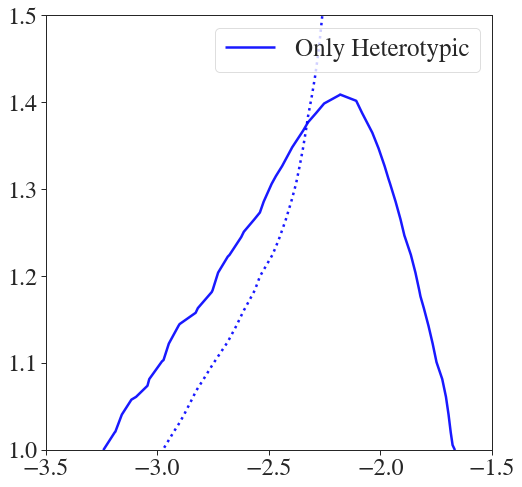

In [221]:
#Plotting the binodal, and the peroclation line
myFig = plt.figure(figsize=[8,8])
myAx  = myFig.subplots(1,1, sharey=True)
rho_cut = 0.025; #The cut-off for the binodal
phi_cut = 0.5    #The cut-off for the perclation threshold.
xgrid, ygrid, OrGrid, PhiGrid = myAnalysis.SysInfo[mySysName]['Order Params']
CS4  = myAx.contour(xgrid, ygrid, OrGrid, rho_cut, colors='blue', linewidths=2.5, alpha=0.9)
CS4.collections[0].set_label(r'Only Heterotypic')
CS4  = myAx.contour(xgrid, ygrid, PhiGrid, phi_cut, colors='blue', linewidths=2.5, alpha=0.9, linestyles='dotted')
myAx.set_xlim(-3.5,-1.5)
myAx.set_ylim(1.0,1.5)
plt.legend(prop={'size':25})
plt.show()